In [4]:
from IPython.core import display
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, cross_validation
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV

%matplotlib inline

In [17]:
def readCsv(name, nrows=6000000):
    df = pd.read_csv(
        "data/expedia/{}.csv".format(name), 
        nrows=nrows,
        parse_dates=["date_time", "srch_ci", "srch_co"])
    df = df[(df.is_booking == True) & (pd.DatetimeIndex(df['date_time']).year == 2014)].sample(100000)
    df["year"] = pd.DatetimeIndex(df['date_time']).year
    df["month"] = pd.DatetimeIndex(df['date_time']).month
    df["hour"] = pd.DatetimeIndex(df['date_time']).hour
    df["dayofweek"] = pd.DatetimeIndex(df['date_time']).dayofweek
    df["hour"] = pd.DatetimeIndex(df['date_time']).hour

    df["srch_ci_month"] = pd.DatetimeIndex(df['srch_ci']).month
    df["srch_ci_dayofweek"] = pd.DatetimeIndex(df['srch_ci']).dayofweek
    
    df["srch_co_month"] = pd.DatetimeIndex(df['srch_co']).month
    df["srch_co_dayofweek"] = pd.DatetimeIndex(df['srch_co']).dayofweek
    
    srch_ci_utime = pd.DatetimeIndex(df['srch_ci']).astype(np.int64) // 10**9 
    srch_co_utime = pd.DatetimeIndex(df['srch_co']).astype(np.int64) // 10**9 
    
    df["srch_days"] = (srch_co_utime - srch_ci_utime) / (3600 * 24)
    
    return df

#df = readCsv("train")
df = pd.read_csv("data/expedia/2014_bookings.csv")
print("shape: ", df.shape)
df.sample(5)

('shape: ', (200000, 34))


,Unnamed: 0,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,...,hotel_cluster,year,month,hour,dayofweek,srch_ci_month,srch_ci_dayofweek,srch_co_month,srch_co_dayofweek,srch_days
166397,650730,2014-07-17 10:10:29,13,1,46,347,22254,NaN,991404,0,...,62,2014,7,10,3,7,6,7,6,7
128815,4176709,2014-11-24 11:26:08,2,3,66,363,14898,NaN,556,0,...,16,2014,11,11,0,12,5,12,6,1
23124,4896682,2014-07-16 20:17:38,2,3,66,442,46296,933.2417,646444,1,...,52,2014,7,20,2,8,5,8,2,4
89394,4749603,2014-06-18 06:02:52,2,3,66,226,42300,152.4633,263119,0,...,59,2014,6,6,2,6,3,6,4,1
33491,922952,2014-02-22 10:06:39,2,3,66,442,35390,5461.4049,653311,0,...,29,2014,2,10,5,3,6,3,5,6



### File descriptions
```
train.csv - the training set
test.csv - the test set
destinations.csv - hotel search latent attributes
sample_submission.csv - a sample submission file in the correct format
```

### Data fields

train/test.csv
```
Column name	Description	Data type
date_time	Timestamp	string
site_name	ID of the Expedia point of sale (i.e. Expedia.com, Expedia.co.uk, Expedia.co.jp, ...)	int
posa_continent	ID of continent associated with site_name	int
user_location_country	The ID of the country the customer is located	int
user_location_region	The ID of the region the customer is located	int
user_location_city	The ID of the city the customer is located	int
orig_destination_distance	Physical distance between a hotel and a customer at the time of search. A null means the distance could not be calculated	double
user_id	ID of user	int
is_mobile	1 when a user connected from a mobile device, 0 otherwise	tinyint
is_package	1 if the click/booking was generated as a part of a package (i.e. combined with a flight), 0 otherwise	int
channel	ID of a marketing channel	int
srch_ci	Checkin date	string
srch_co	Checkout date	string
srch_adults_cnt	The number of adults specified in the hotel room	int
srch_children_cnt	The number of (extra occupancy) children specified in the hotel room	int
srch_rm_cnt	The number of hotel rooms specified in the search	int
srch_destination_id	ID of the destination where the hotel search was performed	int
srch_destination_type_id	Type of destination	int
hotel_continent	Hotel continent	int
hotel_country	Hotel country	int
hotel_market	Hotel market	int
is_booking	1 if a booking, 0 if a click	tinyint
cnt	Numer of similar events in the context of the same user session	bigint
hotel_cluster	ID of a hotel cluster	int
```

destinations.csv
```
Column name	Description	Data type
srch_destination_id	ID of the destination where the hotel search was performed	int
d1-d149	latent description of search regions	double
```

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 199999
Data columns (total 34 columns):
Unnamed: 0                   200000 non-null int64
date_time                    200000 non-null object
site_name                    200000 non-null int64
posa_continent               200000 non-null int64
user_location_country        200000 non-null int64
user_location_region         200000 non-null int64
user_location_city           200000 non-null int64
orig_destination_distance    133493 non-null float64
user_id                      200000 non-null int64
is_mobile                    200000 non-null int64
is_package                   200000 non-null int64
channel                      200000 non-null int64
srch_ci                      200000 non-null object
srch_co                      200000 non-null object
srch_adults_cnt              200000 non-null int64
srch_children_cnt            200000 non-null int64
srch_rm_cnt                  200000 non-null int64
srch_destination_

In [19]:
df.describe()

,Unnamed: 0,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,hotel_cluster,year,month,hour,dayofweek,srch_ci_month,srch_ci_dayofweek,srch_co_month,srch_co_dayofweek,srch_days
count,200000.000000,200000.00000,200000.000000,200000.000000,200000.000000,200000.000000,133493.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000,200000.00000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000
mean,2968980.380510,8.90200,2.710410,86.407160,310.592555,27742.208435,1680.915612,600921.967240,0.103080,0.124855,...,47.672305,2014,7.21187,13.309285,2.721295,7.228360,3.109355,7.149140,3.297860,2.40495
std,1733152.575779,11.55783,0.727132,57.356216,201.268131,16744.860994,2178.921124,346603.687128,0.304064,0.330555,...,28.963255,0,3.25968,5.461572,1.954934,3.328379,1.933203,3.353591,2.073702,2.02480
min,1.000000,2.00000,0.000000,0.000000,0.000000,0.000000,0.005600,12.000000,0.000000,0.000000,...,0.000000,2014,1.00000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.00000
25%,1464997.250000,2.00000,3.000000,66.000000,174.000000,13134.000000,213.091900,296765.000000,0.000000,0.000000,...,22.000000,2014,5.00000,9.000000,1.000000,5.000000,1.000000,5.000000,1.000000,1.00000
50%,2952695.000000,2.00000,3.000000,66.000000,314.000000,27655.000000,765.762500,602792.500000,0.000000,0.000000,...,46.000000,2014,7.00000,13.000000,3.000000,8.000000,3.000000,8.000000,3.000000,2.00000
75%,4467778.500000,11.00000,3.000000,69.000000,385.000000,42328.000000,2196.837900,906969.000000,0.000000,0.000000,...,72.000000,2014,10.00000,18.000000,4.000000,10.000000,5.000000,10.000000,5.000000,3.00000
max,5999992.000000,53.00000,4.000000,239.000000,1025.000000,56507.000000,11917.844900,1198784.000000,1.000000,1.000000,...,99.000000,2014,12.00000,23.000000,6.000000,12.000000,6.000000,12.000000,6.000000,28.00000


### Removing outliers
@TODO: explain what I am doing here.

In [20]:
print "before removing outliers :", df.shape
df = df[(df["srch_days"] < 18) & (df["srch_days"] > -1)]
print "after removing outliers :", df.shape

before removing outliers : (200000, 34)
after removing outliers : (199733, 34)


### Treating Missing values

In [21]:
def removeMisingvalues(df):
    """
    remove data rows associated with any missing value
    """
    return df[
        df.orig_destination_distance.notnull() &
        df.srch_ci.notnull()
    ]

print "before removing missing values :", df.shape
df = removeMisingvalues(df)
print "after removing missing values :", df.shape

before removing missing values : (199733, 34)
after removing missing values : (133348, 34)


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133348 entries, 1 to 199996
Data columns (total 34 columns):
Unnamed: 0                   133348 non-null int64
date_time                    133348 non-null object
site_name                    133348 non-null int64
posa_continent               133348 non-null int64
user_location_country        133348 non-null int64
user_location_region         133348 non-null int64
user_location_city           133348 non-null int64
orig_destination_distance    133348 non-null float64
user_id                      133348 non-null int64
is_mobile                    133348 non-null int64
is_package                   133348 non-null int64
channel                      133348 non-null int64
srch_ci                      133348 non-null object
srch_co                      133348 non-null object
srch_adults_cnt              133348 non-null int64
srch_children_cnt            133348 non-null int64
srch_rm_cnt                  133348 non-null int64
srch_destination_

### Data exploration

In [23]:
def exploreUnivariate(column):
    print "\n-------------------------\nColumn: {}\n".format(column.name)
    print column.describe()
    try:
        sns.distplot(column)
    except:
        print "cannot be plotted"
    plt.show()
#exploreUnivariate(df["srch_days"])
# exploreUnivariate(np.log(df["srch_days"]))  # less skewness


-------------------------
Column: Unnamed: 0

count     133348.000000
mean     2989668.830646
std      1734625.842782
min            1.000000
25%      1489196.000000
50%      2986229.500000
75%      4490017.750000
max      5999924.000000
Name: Unnamed: 0, dtype: float64


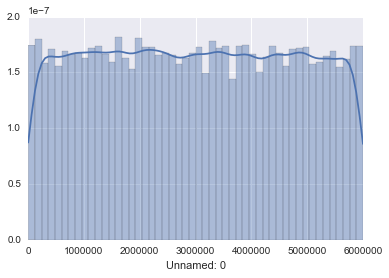


-------------------------
Column: site_name

count    133348.000000
mean          5.803147
std           8.618301
min           2.000000
25%           2.000000
50%           2.000000
75%           2.000000
max          53.000000
Name: site_name, dtype: float64


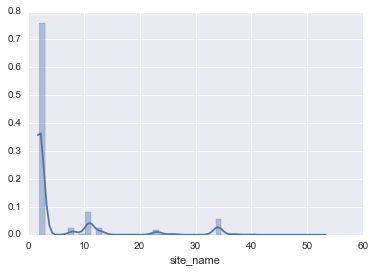


-------------------------
Column: posa_continent

count    133348.000000
mean          2.902391
std           0.526496
min           0.000000
25%           3.000000
50%           3.000000
75%           3.000000
max           4.000000
Name: posa_continent, dtype: float64


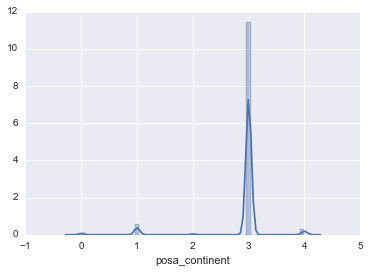


-------------------------
Column: user_location_country

count    133348.000000
mean         86.271905
std          52.505029
min           0.000000
25%          66.000000
50%          66.000000
75%          66.000000
max         215.000000
Name: user_location_country, dtype: float64


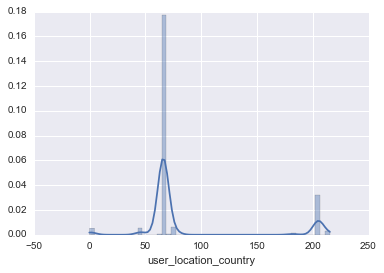


-------------------------
Column: user_location_region

count    133348.000000
mean        309.955927
std         141.006778
min         135.000000
25%         174.000000
50%         318.000000
75%         363.000000
max        1021.000000
Name: user_location_region, dtype: float64


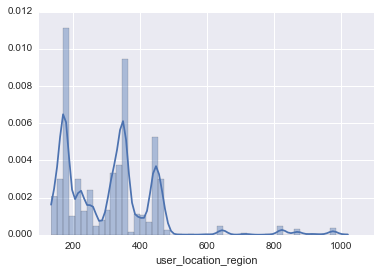


-------------------------
Column: user_location_city

count    133348.000000
mean      27915.649781
std       16564.997453
min           0.000000
25%       14241.000000
50%       27407.000000
75%       42858.000000
max       56507.000000
Name: user_location_city, dtype: float64


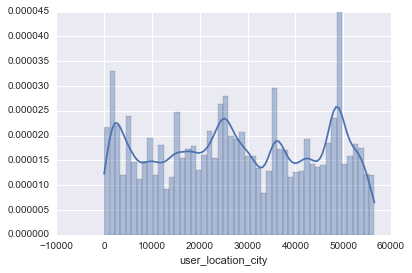


-------------------------
Column: orig_destination_distance

count    133348.000000
mean       1678.780720
std        2177.158572
min           0.005600
25%         212.921850
50%         764.511700
75%        2192.560975
max       11917.844900
Name: orig_destination_distance, dtype: float64


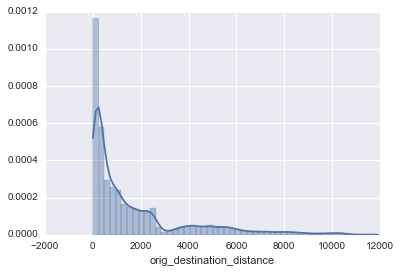


-------------------------
Column: user_id

count     133348.000000
mean      592986.717806
std       343237.674331
min           12.000000
25%       294230.000000
50%       592270.500000
75%       895418.000000
max      1198784.000000
Name: user_id, dtype: float64


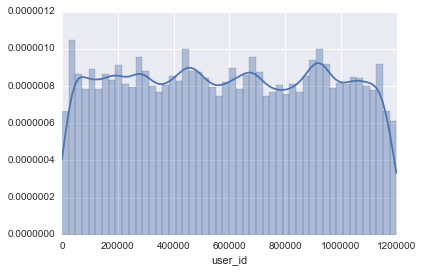


-------------------------
Column: is_mobile

count    133348.000000
mean          0.104688
std           0.306153
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: is_mobile, dtype: float64


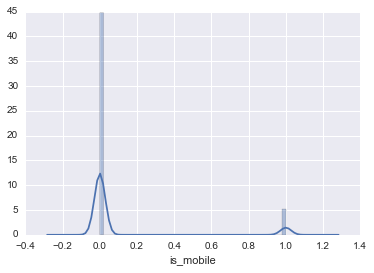


-------------------------
Column: is_package

count    133348.000000
mean          0.116552
std           0.320887
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: is_package, dtype: float64


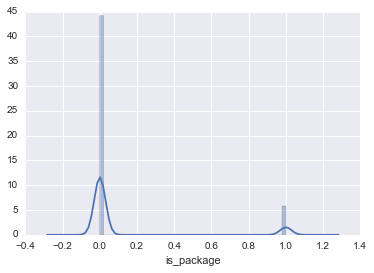


-------------------------
Column: channel

count    133348.000000
mean          6.153388
std           3.654032
min           0.000000
25%           2.000000
50%           9.000000
75%           9.000000
max          10.000000
Name: channel, dtype: float64


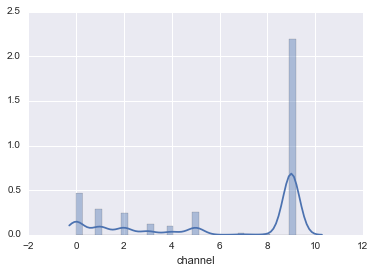


-------------------------
Column: srch_ci

count         133348
unique           696
top       2014-12-26
freq             812
Name: srch_ci, dtype: object
cannot be plotted


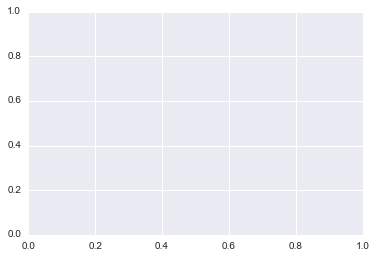


-------------------------
Column: srch_co

count         133348
unique           697
top       2014-12-28
freq             876
Name: srch_co, dtype: object
cannot be plotted


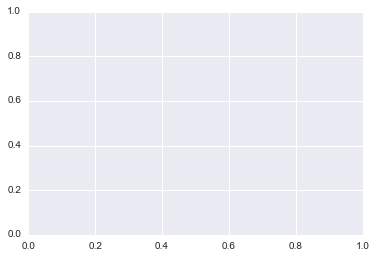


-------------------------
Column: srch_adults_cnt

count    133348.000000
mean          1.907693
std           0.918556
min           0.000000
25%           1.000000
50%           2.000000
75%           2.000000
max           9.000000
Name: srch_adults_cnt, dtype: float64


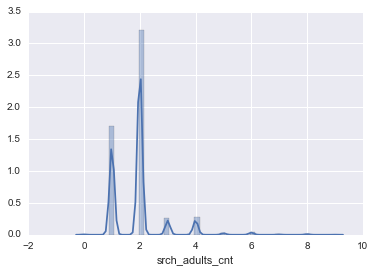


-------------------------
Column: srch_children_cnt

count    133348.000000
mean          0.250127
std           0.666351
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           9.000000
Name: srch_children_cnt, dtype: float64


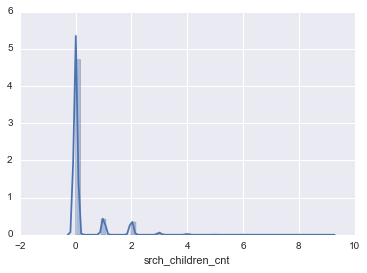


-------------------------
Column: srch_rm_cnt

count    133348.000000
mean          1.126586
std           0.479735
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           8.000000
Name: srch_rm_cnt, dtype: float64


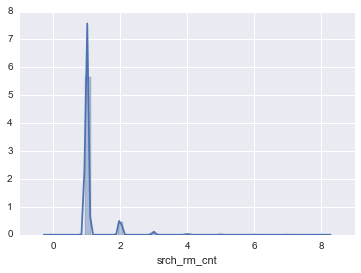


-------------------------
Column: srch_destination_id

count    133348.000000
mean      15512.437772
std       11750.533471
min           4.000000
25%        8266.000000
50%       11975.000000
75%       22648.000000
max       65102.000000
Name: srch_destination_id, dtype: float64


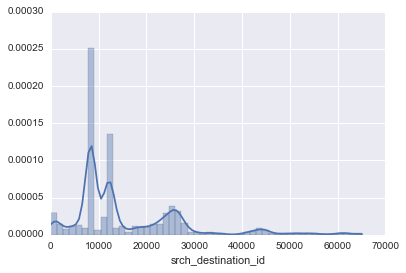


-------------------------
Column: srch_destination_type_id

count    133348.000000
mean          2.886545
std           2.213398
min           1.000000
25%           1.000000
50%           1.000000
75%           6.000000
max           9.000000
Name: srch_destination_type_id, dtype: float64


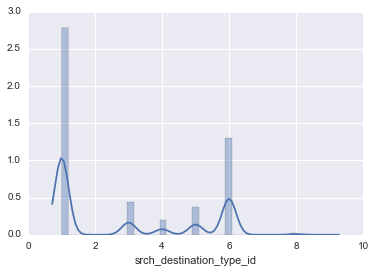


-------------------------
Column: is_booking

count    133348
mean          1
std           0
min           1
25%           1
50%           1
75%           1
max           1
Name: is_booking, dtype: float64
cannot be plotted


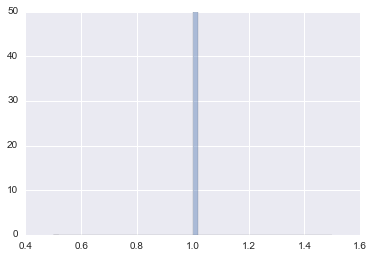


-------------------------
Column: cnt

count    133348.000000
mean          1.014406
std           0.140207
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          11.000000
Name: cnt, dtype: float64


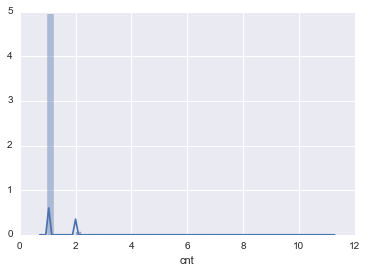


-------------------------
Column: hotel_continent

count    133348.000000
mean          2.675218
std           1.416807
min           0.000000
25%           2.000000
50%           2.000000
75%           2.000000
max           6.000000
Name: hotel_continent, dtype: float64


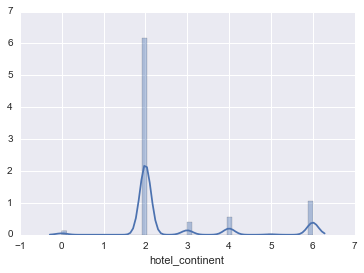


-------------------------
Column: hotel_country

count    133348.000000
mean         73.614722
std          51.778146
min           0.000000
25%          50.000000
50%          50.000000
75%          70.000000
max         212.000000
Name: hotel_country, dtype: float64


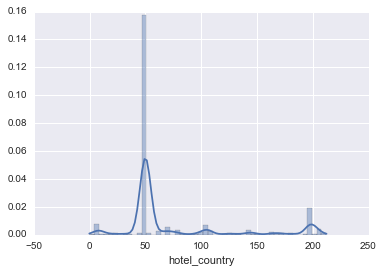


-------------------------
Column: hotel_market

count    133348.000000
mean        639.435222
std         441.062634
min           0.000000
25%         366.000000
50%         628.000000
75%         701.000000
max        2117.000000
Name: hotel_market, dtype: float64


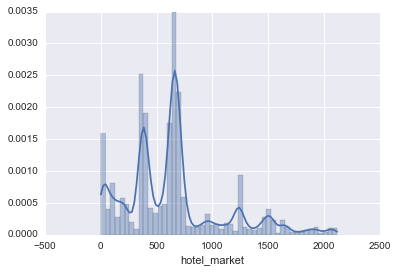


-------------------------
Column: hotel_cluster

count    133348.000000
mean         47.493491
std          29.112451
min           0.000000
25%          21.000000
50%          46.000000
75%          72.000000
max          99.000000
Name: hotel_cluster, dtype: float64


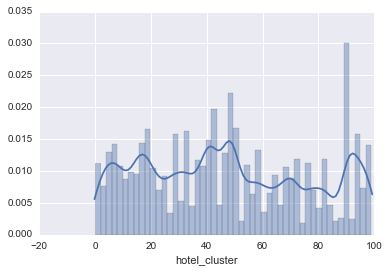


-------------------------
Column: year

count    133348
mean       2014
std           0
min        2014
25%        2014
50%        2014
75%        2014
max        2014
Name: year, dtype: float64
cannot be plotted


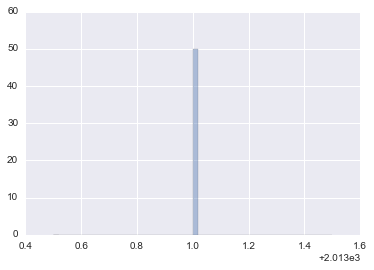


-------------------------
Column: month

count    133348.000000
mean          7.197408
std           3.253623
min           1.000000
25%           5.000000
50%           7.000000
75%          10.000000
max          12.000000
Name: month, dtype: float64


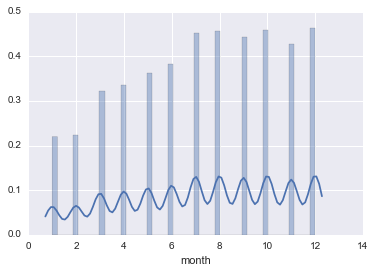


-------------------------
Column: hour

count    133348.000000
mean         13.415949
std           5.188417
min           0.000000
25%          10.000000
50%          13.000000
75%          18.000000
max          23.000000
Name: hour, dtype: float64


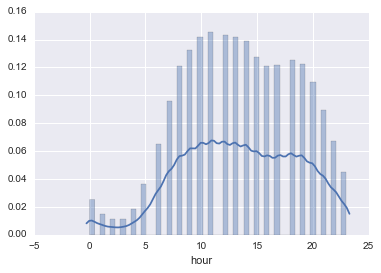


-------------------------
Column: dayofweek

count    133348.000000
mean          2.695758
std           1.948024
min           0.000000
25%           1.000000
50%           3.000000
75%           4.000000
max           6.000000
Name: dayofweek, dtype: float64


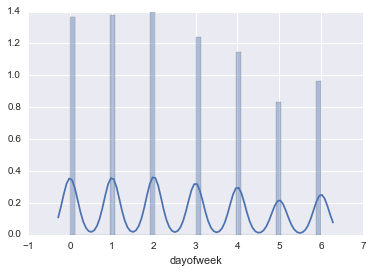


-------------------------
Column: srch_ci_month

count    133348.000000
mean          7.229182
std           3.315456
min           1.000000
25%           5.000000
50%           8.000000
75%          10.000000
max          12.000000
Name: srch_ci_month, dtype: float64


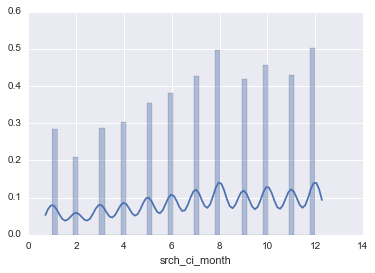


-------------------------
Column: srch_ci_dayofweek

count    133348.000000
mean          3.126391
std           1.920803
min           0.000000
25%           2.000000
50%           3.000000
75%           5.000000
max           6.000000
Name: srch_ci_dayofweek, dtype: float64


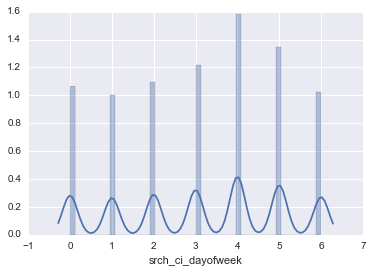


-------------------------
Column: srch_co_month

count    133348.000000
mean          7.157933
std           3.338320
min           1.000000
25%           5.000000
50%           8.000000
75%          10.000000
max          12.000000
Name: srch_co_month, dtype: float64


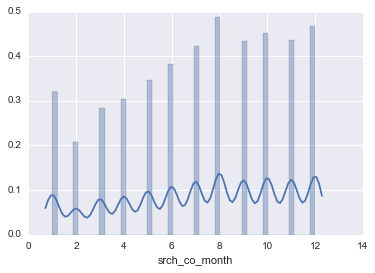


-------------------------
Column: srch_co_dayofweek

count    133348.000000
mean          3.343095
std           2.081142
min           0.000000
25%           2.000000
50%           4.000000
75%           5.000000
max           6.000000
Name: srch_co_dayofweek, dtype: float64


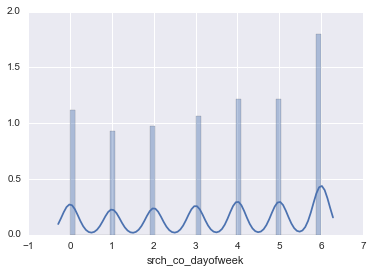


-------------------------
Column: srch_days

count    133348.000000
mean          2.281197
std           1.804944
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          17.000000
Name: srch_days, dtype: float64


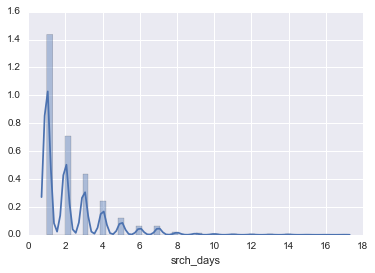

In [24]:
for i in df.drop(labels=["date_time"], axis=1).columns:
    exploreUnivariate(df[i])

In [11]:
# @TODO: plot bivariate charts

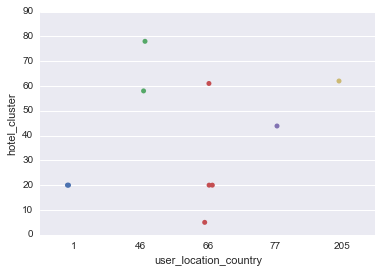

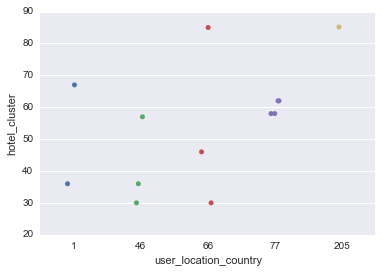

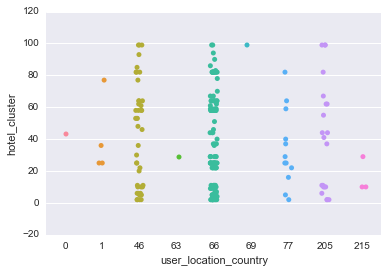

In [25]:
sns.stripplot(x="user_location_country", y="hotel_cluster", jitter=True, data=df[
            (df["hotel_country"] == 19) & (df["year"] == 2014)])
plt.show()
sns.stripplot(x="user_location_country", y="hotel_cluster", jitter=True ,data=df[
            (df["hotel_country"] == 20) & (df["year"] == 2014)])
plt.show()
sns.stripplot(x="user_location_country", y="hotel_cluster", jitter=True, data=df[
            (df["hotel_country"] == 21) & (df["year"] == 2014)])
plt.show()

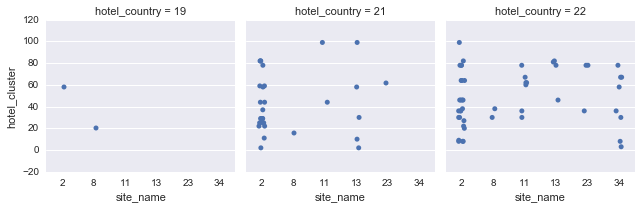

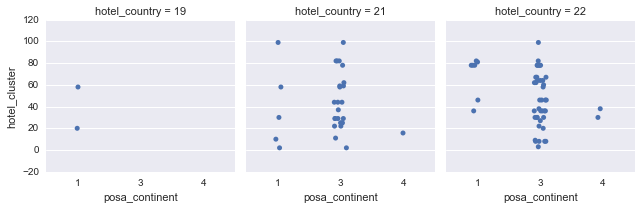

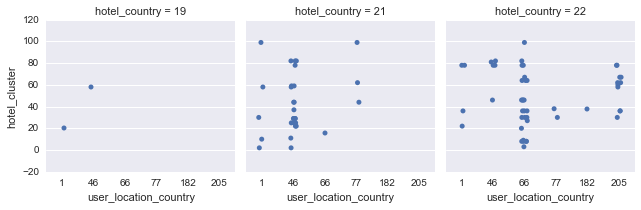

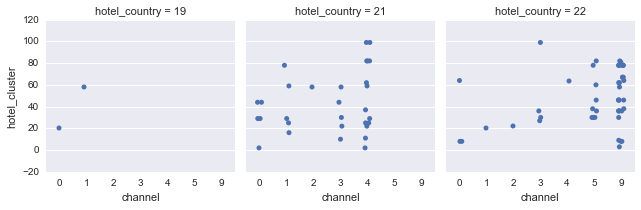

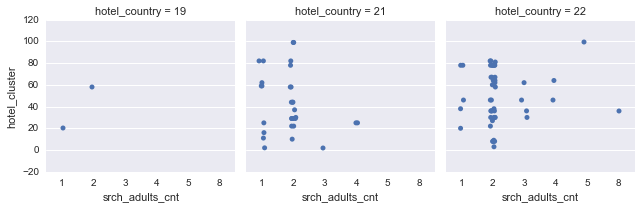

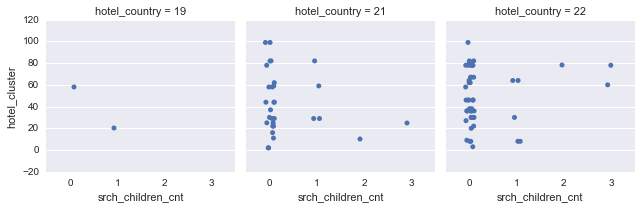

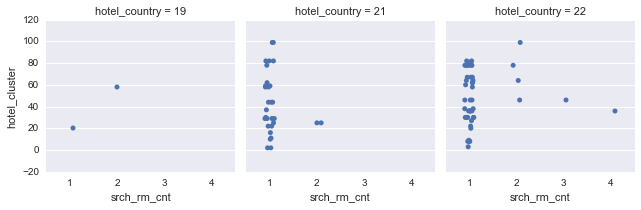

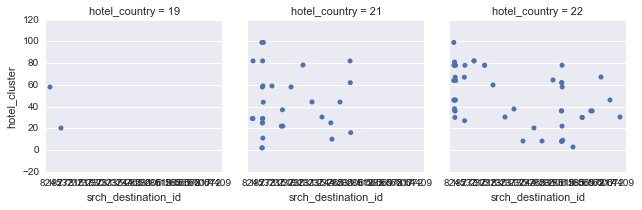

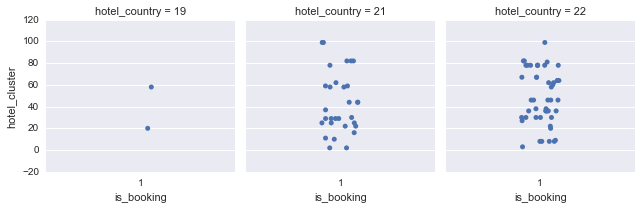

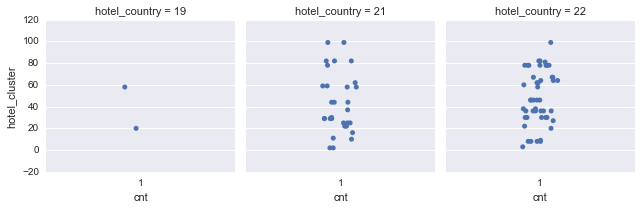

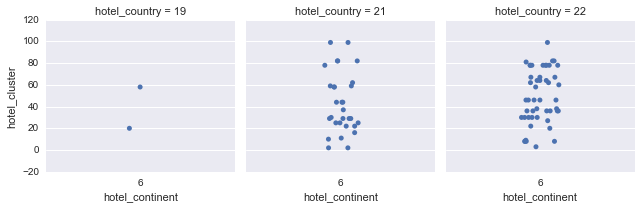

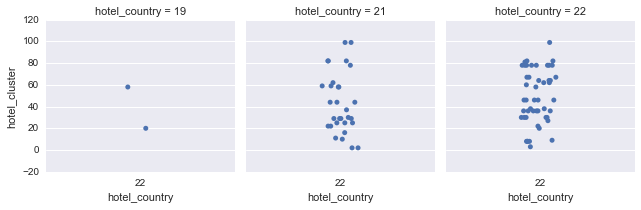

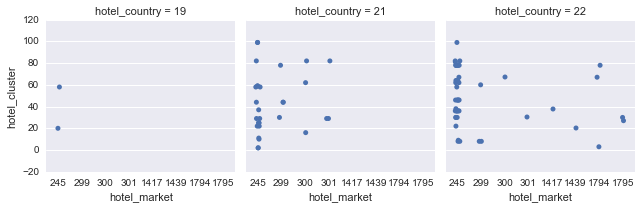

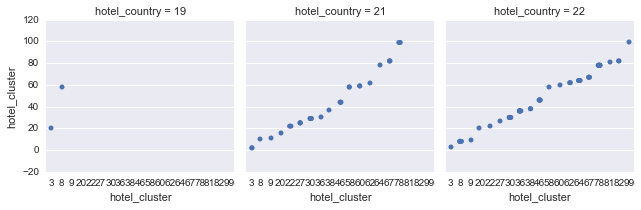

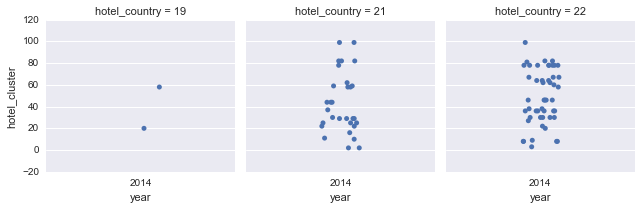

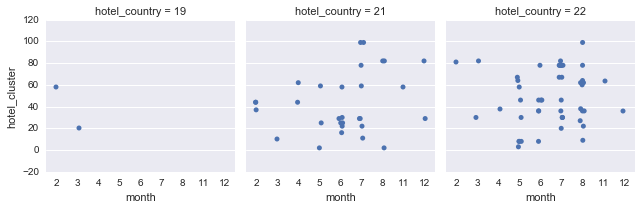

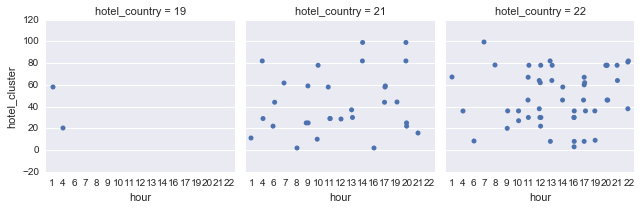

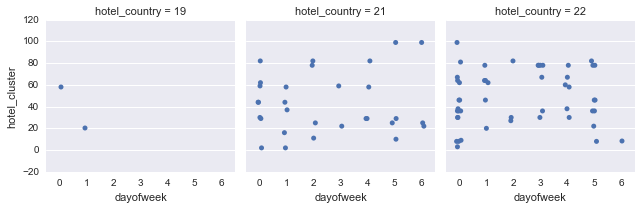

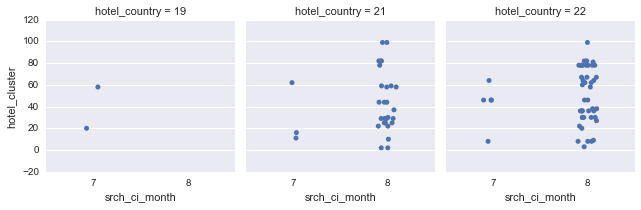

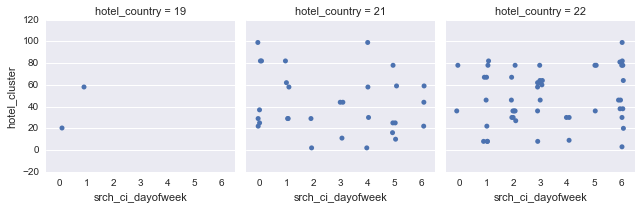

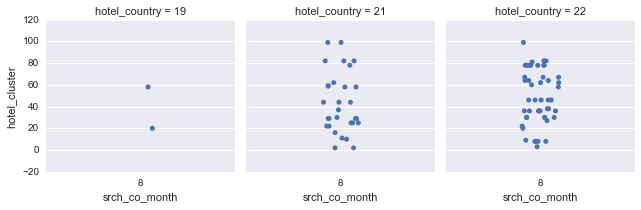

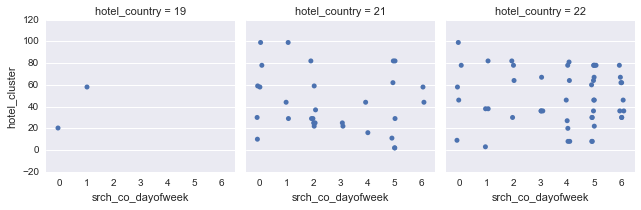

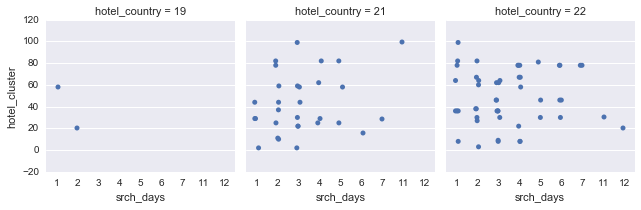

In [34]:
cols = [u'site_name', u'posa_continent', u'user_location_country',
       u'channel', u'srch_adults_cnt',
       u'srch_children_cnt', u'srch_rm_cnt', u'srch_destination_id',
       u'is_booking', u'cnt', u'hotel_continent',
       u'hotel_country', u'hotel_market', u'hotel_cluster', u'year', u'month',
       u'hour', u'dayofweek', u'srch_ci_month', u'srch_ci_dayofweek',
       u'srch_co_month', u'srch_co_dayofweek', u'srch_days']

for i in cols:
    g = sns.FacetGrid(
        df[
            (
                (df["hotel_country"] == 19) | 
                (df["hotel_country"] == 20) | 
                (df["hotel_country"] == 21) | 
                (df["hotel_country"] == 22) 
            ) 
            & (df["year"] == 2014)
            & (df["srch_co_month"] == 8)
        ], col="hotel_country")
    g.map(sns.stripplot, i, "hotel_cluster", jitter=True)
    #g.add_legenad();
    #sns.boxplot(x=i, y="hotel_cluster", data=df[
    #        (df["hotel_country"] == 21) & (df["year"] == 2014)])
    plt.show()


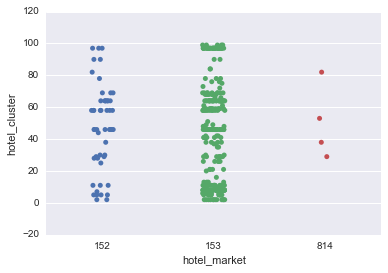

In [29]:
sns.stripplot(
    x="hotel_market", y="hotel_cluster", 
    data=df[df["hotel_country"] == 48], jitter=True)

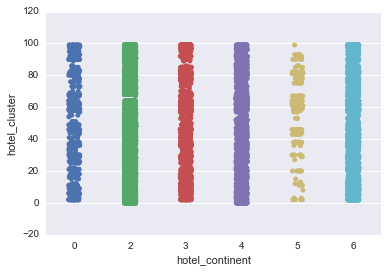

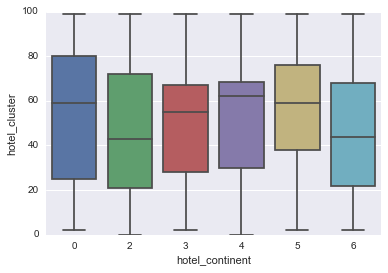

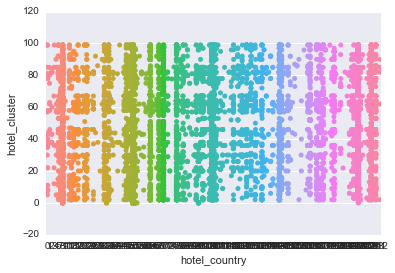

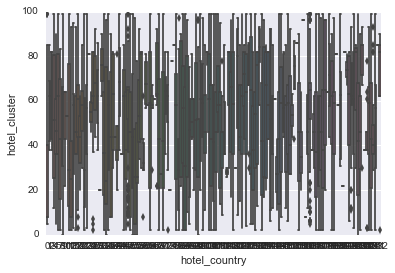

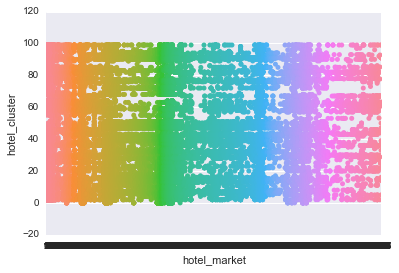

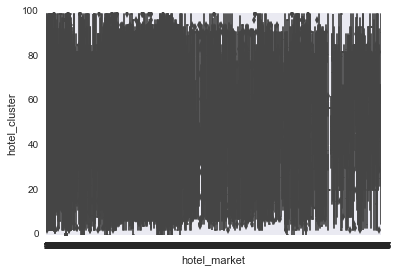

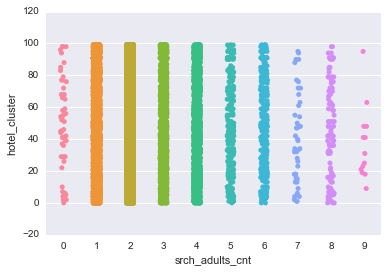

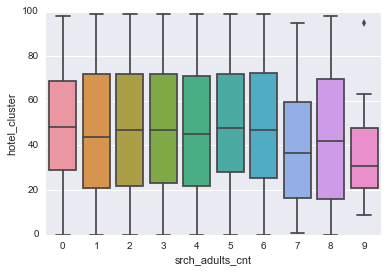

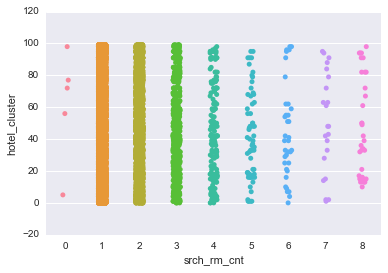

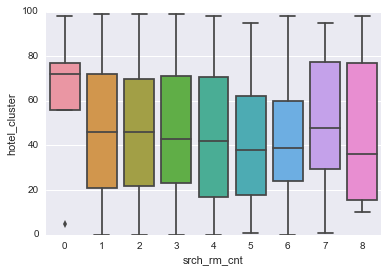

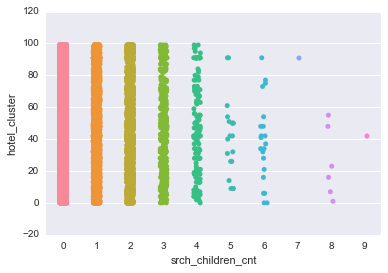

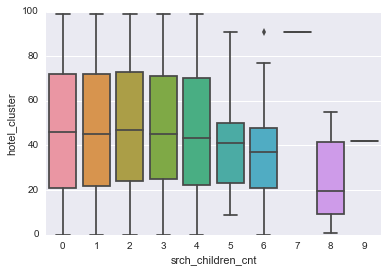

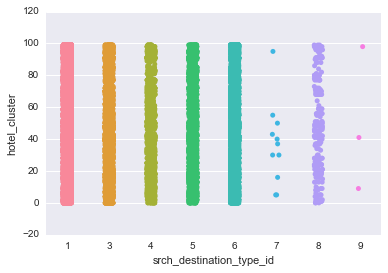

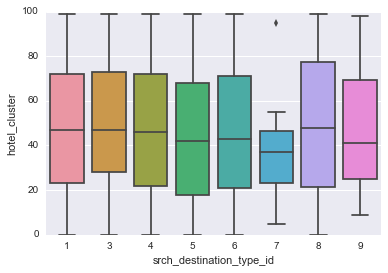

KeyboardInterrupt: 

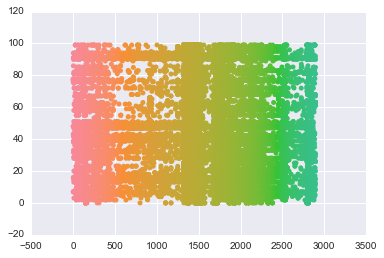

In [32]:
def biVariate(df):
    cols = [
        #"srch_destination_id"]
        "hotel_continent", "hotel_country",
        "srch_adults_cnt", "srch_rm_cnt", "srch_children_cnt", 
        "srch_destination_type_id", "srch_destination_id",
        "month", "year", "hour", "dayofweek", "srch_ci_month", 
        "srch_ci_dayofweek", "srch_co_month", "srch_co_dayofweek", "srch_days"]
    for i in cols:
        sns.stripplot(x=i, y="hotel_cluster", data=df, jitter=True)
        plt.show()
        sns.boxplot(x=i, y="hotel_cluster", data=df)
        plt.show()
biVariate(df.sample(50000))

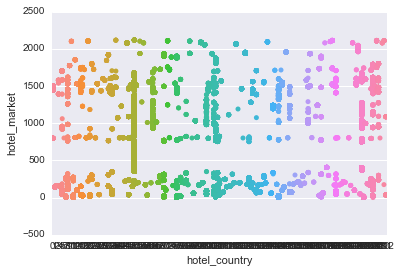

In [21]:
sns.stripplot(x="hotel_country", y="hotel_market", data=df, jitter=True)

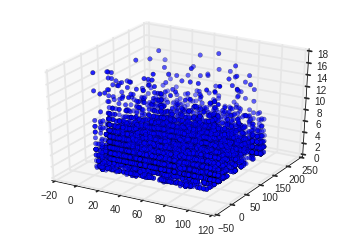

In [14]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(df["hotel_cluster"], df["hotel_country"], df["srch_days"], c="b")

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 3833548 to 2732975
Data columns (total 33 columns):
date_time                    50000 non-null datetime64[ns]
site_name                    50000 non-null int64
posa_continent               50000 non-null int64
user_location_country        50000 non-null int64
user_location_region         50000 non-null int64
user_location_city           50000 non-null int64
orig_destination_distance    33080 non-null float64
user_id                      50000 non-null int64
is_mobile                    50000 non-null int64
is_package                   50000 non-null int64
channel                      50000 non-null int64
srch_ci                      50000 non-null object
srch_co                      50000 non-null object
srch_adults_cnt              50000 non-null int64
srch_children_cnt            50000 non-null int64
srch_rm_cnt                  50000 non-null int64
srch_destination_id          50000 non-null int64
srch_destination_typ

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation

In [11]:
clf = RandomForestClassifier(n_estimators=10)

a = df[[
        "hotel_continent",
        "hotel_market",
        "user_location_country",
        "srch_destination_type_id", 
        "hotel_country", 
        "is_package",
        "srch_ci_month", 
        "srch_days",
        "hotel_cluster"
    ]]

X = a.drop(labels=["hotel_cluster"], axis=1)
y = a["hotel_cluster"]

X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    X, y, test_size=0.2, random_state=0)


clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.13171250000000001

In [ ]:
from sklearn.svm import SVC

clf = SVC(kernel="rbf", gamma=0.002)

a = df[[
        "hotel_continent",
        "hotel_market",
        "user_location_country",
        "srch_destination_type_id", 
        "hotel_country", 
        "is_package",
        "srch_ci_month", 
        "srch_days",
        "hotel_cluster"
    ]]

X = a.drop(labels=["hotel_cluster"], axis=1)
y = a["hotel_cluster"]

X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    X, y, test_size=0.2, random_state=0)


clf.fit(X_train, y_train)
clf.score(X_test, y_test)

In [2]:
dest = pd.read_csv("data/expedia/destinations.csv")

In [4]:
dest.sample(5)

,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
26231,27437,-2.207447,-2.213283,-2.213283,-2.184263,-2.042806,-2.158912,-2.213283,-2.213283,-2.213283,...,-2.213283,-2.183072,-2.177808,-2.213283,-2.114200,-2.213283,-2.181598,-2.213283,-2.213283,-2.152779
24091,25276,-2.180774,-2.180774,-2.180774,-2.180774,-2.180774,-2.149468,-2.180774,-2.180774,-2.180774,...,-2.180774,-2.180774,-2.180774,-2.180774,-2.180774,-2.180774,-2.180774,-2.180774,-2.180774,-2.180774
50521,52761,-2.311128,-2.300818,-2.313542,-2.208092,-1.889265,-1.681330,-2.313542,-2.313542,-2.253724,...,-2.312284,-2.313195,-2.313542,-2.268086,-2.268086,-2.313542,-2.313542,-2.313542,-2.313542,-2.201945
9479,9783,-2.181958,-2.181958,-2.181958,-2.181958,-2.181958,-2.172306,-2.181958,-2.181958,-2.172306,...,-2.172306,-2.181958,-2.181958,-2.181958,-2.181958,-2.181958,-2.181958,-2.181958,-2.181958,-2.181958
24922,26116,-2.192287,-2.192287,-2.192287,-2.192287,-2.192287,-2.155291,-2.192287,-2.192287,-2.192287,...,-2.185266,-2.192287,-2.192287,-2.192287,-2.192287,-2.192287,-2.192287,-2.192287,-2.192287,-2.192287


In [11]:
import pymongo
from pprint import pprint as pp
from datetime import datetime


In [60]:
db = pymongo.MongoClient("192.168.5.5")["expedia2"]

In [70]:
i = 0
with open("data/expedia/train.csv") as f:
    cache = []
    headers = f.readline().strip().split(",") # reading the header line, we do not need this.
    strptime_format1 = "%Y-%m-%d %H:%M:%S"
    strptime_format2 = "%Y-%m-%d"
    
    def toInt(line):
        for h in headers:
            if h not in ["date_time", "srch_ci", "srch_co"]:
                line[h] = float(line[h])
        return line
    
    for line in f:
        i += 1
        line = line.strip().split(",")
        if line[18] == 0:
            continue

        line = dict(zip(headers, line))
        if line["orig_destination_distance"] == "":
            continue
        
        if line["srch_ci"] == "" or line["srch_co"] == "":
            continue

#         line["date_time"] = datetime.strptime(line["date_time"], strptime_format)
#         line["srch_ci"] = datetime.strptime(line["srch_ci"], strptime_format2)
#         line["srch_co"] = datetime.strptime(line["srch_co"], strptime_format2)
#         line = toInt(line)
#         pp(line)
        
        cache.append(line)
        if len(cache) == 10000:
            # print "inserting , ", i, len(cache)
            db["train2"].insert_many(cache)
            cache = []

        if i % 40000 == 0:
            print i

40000
80000
120000
160000
280000
320000
360000
400000


KeyboardInterrupt: 

In [71]:
headers

['date_time',
 'site_name',
 'posa_continent',
 'user_location_country',
 'user_location_region',
 'user_location_city',
 'orig_destination_distance',
 'user_id',
 'is_mobile',
 'is_package',
 'channel',
 'srch_ci',
 'srch_co',
 'srch_adults_cnt',
 'srch_children_cnt',
 'srch_rm_cnt',
 'srch_destination_id',
 'srch_destination_type_id',
 'is_booking',
 'cnt',
 'hotel_continent',
 'hotel_country',
 'hotel_market',
 'hotel_cluster']